# Data Preparation

## Make Dataset

Data from https://nrc-digital-repository.canada.ca/eng/view/object/?id=1343ae23-cebf-45c6-94c3-ddebdb2f23c6

Paper: https://journals.aps.org/pra/abstract/10.1103/PhysRevA.96.042113

In [37]:
import torch
from quantum_dataset import QuantumDataset

torch.cuda.empty_cache()
potential_type = 'all'
dset = QuantumDataset(potential_type)
files = dset.get_files()

HO_gen2_0010.h5
calculated_energy: (5000, 1)
cx: (5000, 1)
cy: (5000, 1)
kx: (5000, 1)
ky: (5000, 1)
potential: (5000, 1, 256, 256)
psi: (5000, 1, 256, 256)
theoretical_energy: (5000, 1)

IW_gen2_0010.h5
calculated_energy: (5000, 1)
cx: (5000, 1)
cy: (5000, 1)
eigenvalues: (5000, 5)
potential: (5000, 1, 256, 256)
theoretical_energy: (5000, 1)
wavefunction: (5000, 1, 256, 256)
wx: (5000, 1)
wy: (5000, 1)

NG_gen2b_0000.h5
calculated_energy: (5000, 1)
eigenvalues: (5000, 5)
parameters: (5000, 10)
potential: (5000, 1, 256, 256)
wavefunction: (5000, 1, 256, 256)

RND_0011.h5
calculated_energy: (5000, 1)
eigenvalues: (5000, 5)
potential: (5000, 1, 256, 256)
wavefunction: (5000, 1, 256, 256)

RND_KE_gen2_0010.h5
calculated_energy: (5000, 1)
eigenvalues: (5000, 5)
kinetic_energy: (5000, 1)
potential: (5000, 1, 256, 256)
wavefunction: (5000, 1, 256, 256)



  0%|          | 0/5 [00:00<?, ?it/s]

## Image Plotting Function

In [38]:
import matplotlib.pyplot as plt
from torch import Tensor
def print_img(image1:Tensor,
              image2:Tensor,
              title1:str=None,
              title2:str=None,
              energy:Tensor=None,
              potential_label:str=None,
              energy_pred:Tensor=None,
              energy_diff:bool=False)->None:
    '''
    Function for Plotting Images
    :param image1: 256x256 image of potential or wavefunction
    :param image2: 256x256 image of potential or wavefunction
    :param title1: Title of the first image
    :param title2: Title of the second image
    :param energy: Energy of wavefunction
    :param potential_label: Label of potential
    :param energy_pred: Predicted energy from the model
    :param energy_diff: True to display the difference in energy and energy_pred
    :return: None
    '''
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    cmap = 'viridis'

    img = ax[0].imshow(image1.permute(1,2,0).cpu().numpy(),cmap=cmap)
    plt.colorbar(img)
    ax[0].set_title(title1)
    ax[0].axis('image')
    if potential_label is not None:
        ax[0].set_xlabel(files[potential_label.item()])
    ax[0].tick_params(labelbottom=False,labelleft=False)

    img = ax[1].imshow(image2.permute(1,2,0).cpu().numpy(),cmap=cmap)
    plt.colorbar(img)
    ax[1].set_title(title2)
    ax[1].axis('image')
    if energy is not None:
        energy = energy.cpu()
        if energy_pred is None:
            ax[1].set_xlabel(rf'$E_{{True}} = {energy.item():.2f}$')
        elif not energy_diff:
            energy_pred = energy_pred.cpu()
            ax[1].set_xlabel(rf'$E_{{True}} = {energy.item():.2f}$'+'\n'+rf'$E_{{Calc}} = {energy_pred.item():.2f}$')
        else:
            energy_pred = energy_pred.cpu()
            ax[1].set_xlabel(rf'$E_{{Calc}} = {energy_pred.item():.2f}$'+'\n'+rf'$\Delta E = {torch.abs(energy-energy_pred).item():.4e}$')

    ax[1].tick_params(labelbottom=False,labelleft=False)

    plt.show()
    plt.close(fig)


## Sample Data

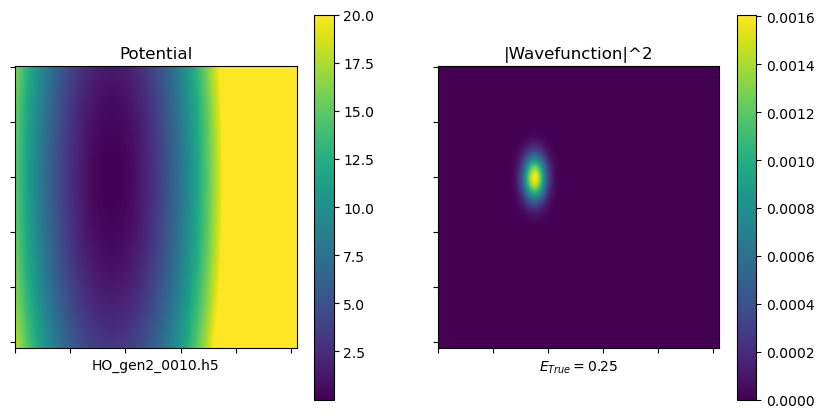

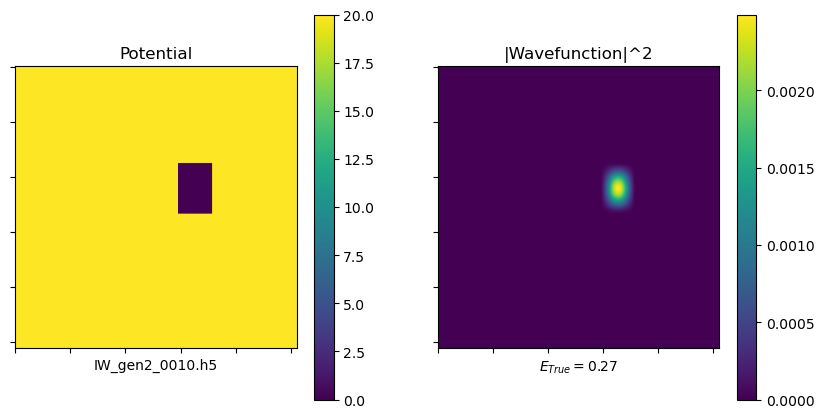

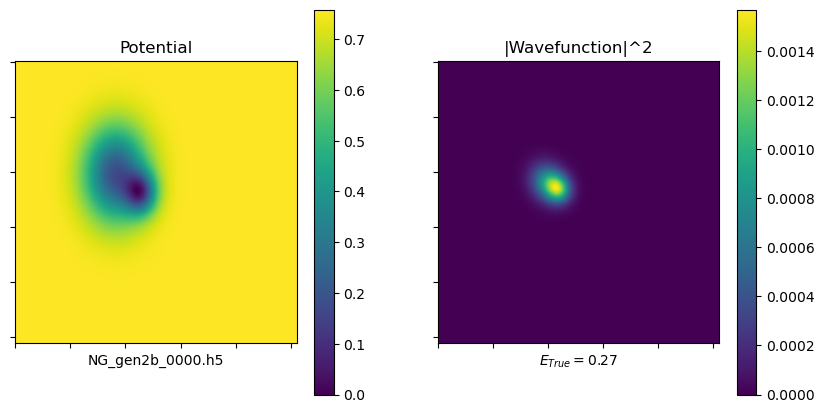

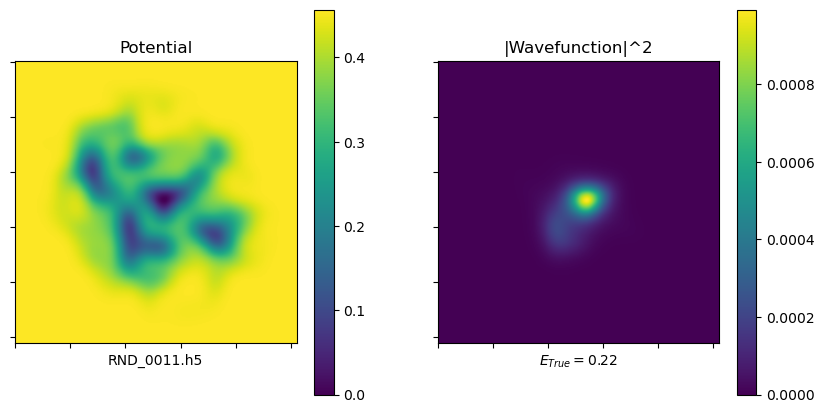

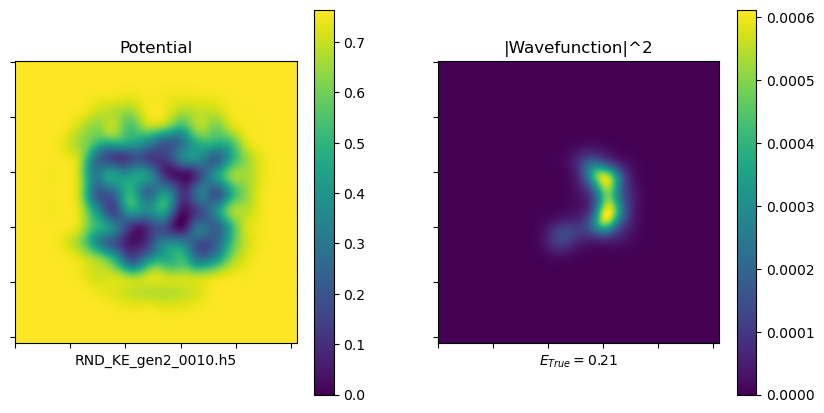

In [39]:
sample_idx = [0,5000,10000,15000,20000] if potential_type == 'all' else [0]
for idx in sample_idx:
    potential = dset[idx]['potential']
    wavefunction2 = dset[idx]['wavefunction2']
    energy = dset[idx]['energy']
    potential_label = dset[idx]['potential_label']
    print_img(potential,wavefunction2,'Potential','|Wavefunction|^2',energy,potential_label)

## Split Data

In [40]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

seed = 12

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

train_generator = torch.Generator()
train_generator.manual_seed(seed)

val_generator = torch.Generator()
val_generator.manual_seed(seed)

test_generator = torch.Generator()
test_generator.manual_seed(seed)

train_dataset, test_dataset = train_test_split(dset, test_size=0.2, shuffle=True,random_state=seed)
train_dataset, validation_dataset = train_test_split(train_dataset, test_size=0.2, shuffle=True,random_state=seed)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True,generator=train_generator)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=True,generator=val_generator)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True,generator=test_generator)

# Part 1

## Create Model

In [41]:
from torch import nn
import math

class EnergyCNN(nn.Module):
    def __init__(self, cnn_channels:tuple,hidden_layers:tuple=()):
        '''
        Model for predicting energy of a wavefunction using a potential map
        :param cnn_channels: Tuple of tuples containing parameters for each CNN layer
        :param hidden_layers: Tuple containing ints describing output for each hidden layer
        '''
        super().__init__()

        cnn_layers = []
        if cnn_channels:
            cnn_layers.append(nn.Conv2d(1,cnn_channels[0][0],cnn_channels[0][1],stride=cnn_channels[0][2],padding=cnn_channels[0][3], padding_mode='replicate'))
            cnn_layers.append(nn.ReLU())
            for i in range(len(cnn_channels)-1):
                cnn_layers.append(nn.Conv2d(cnn_channels[i][0],cnn_channels[i+1][0],cnn_channels[i+1][1],stride=cnn_channels[i+1][2],padding=cnn_channels[i+1][3], padding_mode='replicate'))
                cnn_layers.append(nn.ReLU())

        self.cnn_stack = nn.Sequential(*cnn_layers)
        cnn_output = self.cnn_stack(torch.zeros(1,256,256))

        linear_layers = []
        if hidden_layers:
            linear_layers.append(nn.Flatten())
            linear_layers.append(nn.Linear(cnn_output.numel(),hidden_layers[0]))
            linear_layers.append(nn.ReLU())
            for i in range(len(hidden_layers)-1):
                linear_layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
                linear_layers.append(nn.ReLU())
            linear_layers.append(nn.Linear(hidden_layers[-1], 1))
        else:
            linear_layers.append(nn.Linear(math.prod(cnn_output),1))
        self.linear_stack = nn.Sequential(*linear_layers)

    def forward(self,X:Tensor)->Tensor:
        '''
        Predicts energy for the wavefunction
        :param X: Potential image
        :return: Energy prediction
        '''
        X = self.linear_stack(self.cnn_stack(X))
        return X

## Train Model

In [42]:
from tqdm.notebook import tqdm

def energy_test(model:nn.Module,
                dataloader:DataLoader,
                loss_fn:nn.Module,
                device:str,
                validate:bool=False)->None:
    '''
    Testing loop for the EnergyCNN
    :param model: Model used for testing
    :param dataloader: DataLoader containing validate or test data
    :param loss_fn: Loss function used in training
    :param device: CPU or CUDA
    :param validate: True for validation tests else False
    :return: None
    '''
    model.eval()
    losses = []
    with torch.inference_mode():
        for data in dataloader:
            X = data['potential'].to(device)
            y = data['energy'].to(device)
            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            losses.append(loss.item())
        average_loss = sum(losses) / len(losses)
        test_type = 'Validation' if validate else 'Test'
        tqdm.write(f'{test_type} Loss: {average_loss}\n')

In [43]:
from torch.optim import Optimizer

def energy_train(model:nn.Module,
                 epochs:int,
                 train_dataloader:DataLoader,
                 validation_dataloader:DataLoader,
                 optimizer:Optimizer,
                 loss_fn:nn.Module,
                 device='cuda')->None:
    '''
    Training loop for the EnergyCNN
    :param model: Model used for training
    :param epochs: Number of cycles
    :param train_dataloader: Dataloader containing training data
    :param validation_dataloader: Dataloader containing validation data
    :param optimizer: Optimizer used for training
    :param loss_fn: Loss function used in training
    :param device: CPU or CUDA
    :return: None
    '''
    for epoch in tqdm(range(epochs),unit='epochs',position=0):
        model.train()
        losses = []
        for data in tqdm(train_dataloader,unit='batches',leave=False,position=1):
            optimizer.zero_grad()
            X = data['potential'].to(device)
            y = data['energy'].to(device)

            loss = loss_fn(model(X), y)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        avg_loss = sum(losses) / len(losses)

        tqdm.write(f'Epoch {epoch + 1}/{epochs}\nTrain Loss: {avg_loss}')

        energy_test(model,validation_dataloader,loss_fn,device,validate=True)

In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = EnergyCNN(cnn_channels=((64,3,2,1),
                                (16,3,2,1),
                                (64,3,2,1),
                                (16,3,2,1)),
                  hidden_layers=(64,),
                  ).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

epochs = 1
energy_train(model,epochs,train_dataloader,validation_dataloader,optimizer,loss_fn,device)
energy_test(model,test_dataloader,loss_fn,device,validate=False)


  0%|          | 0/1 [00:00<?, ?epochs/s]

  0%|          | 0/1000 [00:00<?, ?batches/s]

Epoch 1/1
Train Loss: 0.005745785337872803
Validation Loss: 0.004294454812072217

Test Loss: 0.004270136502523797



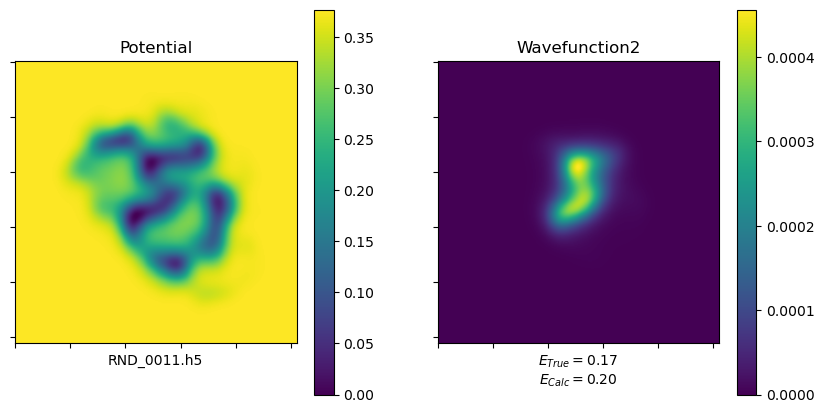

In [45]:
presentation_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

limit = 1
model.eval()
for i, data in enumerate(presentation_dataloader):
    if i >= limit:
        break

    potential = data['potential']
    wavefunction2 = data['wavefunction2']
    energy = data['energy']
    potential_label = data['potential_label']
    with torch.inference_mode():
        energy_pred = model.forward(potential.to(device))
        print_img(potential.squeeze(dim=0),wavefunction2.squeeze(dim=0),'Potential','Wavefunction2',energy,potential_label,energy_pred)

# Part 2

## Energy Loss

Based on the time-independent schrodinger equation


-> -1/2 * delta^2 psi + V * psi = E * psi

H = -1/2 delta^2 + V

H psi = E psi

In [46]:
from torch import nn

class EnergyLoss(nn.Module):
    def __init__(self,alpha:float=1.,gamma:float=0.,dx:float=0.157,loss_fn:nn.Module=nn.L1Loss(reduction='mean')):
        '''
        Loss function for calculating the difference in energy between true energy and energy predicted from a wavefunction
        :param alpha: Value that linearly scales the output of the loss
        :param gamma: Determines type of kernel used for the laplacian
        :param dx: Distance between pixels
        :param loss_fn: Loss function used to evaluate energy differences
        '''
        super().__init__()
        self.alpha = alpha
        self.loss_fn = loss_fn
        with torch.no_grad():
            self.laplacian = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3,padding=1,padding_mode='reflect',bias=False)
            kernel = (1-gamma)*torch.tensor([[0,1,0],[1,-4,1],[0,1,0]])+gamma*torch.tensor([[1/2,0,1/2],[0,-2,0],[1/2,0,1/2]])
            self.laplacian.weight[:] = kernel.reshape(1,1,3,3)/(dx**2)

    def forward(self,potential:Tensor,wavefunction:Tensor,energy:Tensor)->Tensor:
        '''
        Calculates loss between True and predicted energy
        :param potential: Potential Image
        :param wavefunction: Wavefunction Prediction
        :param energy: True Energy
        :return: loss between True energy and energy from wavefunction
        '''
        energy_pred = self.get_energy(potential,wavefunction)
        loss = self.loss_fn(energy_pred,energy)
        return loss*self.alpha

    def get_ke(self,wavefunction:Tensor)->Tensor:
        '''
        Calculates Kinetic Energy of the wavefunction
        :param wavefunction: Wavefunction Prediction
        :return: Kinetic Energy
        '''
        return -1/2 * self.laplacian(wavefunction)

    def get_energy(self,potential:Tensor,wavefunction:Tensor)->Tensor:
        '''
        Calculates the energy of the wavefunction
        :param potential: Potential Image
        :param wavefunction: Wavefunction Prediction
        :return: Predicted Energy
        '''
        energy_pred = (self.get_ke(wavefunction) * wavefunction + potential * wavefunction**2).sum(dim=(2,3))/(wavefunction**2).sum(dim=(2,3))
        return energy_pred



## Create Model

In [47]:
class WavefunctionPINN(nn.Module):
    def __init__(self,channels:list=None):
        '''
        UNET model designed to predict wavefunctions given their potentials
        :param channels: List containing number of channels per layer
        '''
        super().__init__()
        self.start = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=channels[0],kernel_size=3,padding=1,padding_mode='reflect'),
                                   nn.ReLU(),
                                   nn.Conv2d(in_channels=channels[0],out_channels=channels[0],kernel_size=3,padding=1,padding_mode='reflect'),
                                   nn.ReLU())
        self.end = nn.Sequential(nn.Conv2d(in_channels=channels[0],out_channels=1,kernel_size=3,padding=1,padding_mode='reflect'),
                                 nn.Tanh(),
                                 )
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        for i in range(1,len(channels)):
            self.encoders.append(self.make_encoder(channels[i-1],channels[i]))
            self.decoders.append(self.make_decoder(channels[i],channels[i-1],channels[i-1]))
        self.bridge = nn.Sequential(
            nn.Dropout2d(p=0.1),
            nn.Conv2d(in_channels=channels[-1],out_channels=channels[-1],kernel_size=3,padding=1,padding_mode='reflect'),
            nn.ReLU(),
            nn.Conv2d(in_channels=channels[-1],out_channels=channels[-1],kernel_size=3,padding=1,padding_mode='reflect'),
            nn.ReLU(),
            nn.Conv2d(in_channels=channels[-1],out_channels=channels[-1],kernel_size=3,padding=1,padding_mode='reflect'),
            nn.ReLU(),
        )

    def forward(self,X:Tensor)->Tensor:
        '''
        Predicts wavefunction using potential energy
        :param X: Potential Image
        :return: Wavefunction Prediction
        '''

        X = self.start(X)
        encoded_levels = []
        for encoder in self.encoders:
            encoded_levels.append(X)
            X = encoder(X)
        X = self.bridge(X)
        for i in range(len(self.decoders)-1,-1,-1):
            X = self.decoders[i]['decode'](X)
            X = self.decoders[i]['convolution'](torch.cat((X, encoded_levels[i]), dim=1))
        X = self.end(X)
        X = X * torch.sqrt(1/(X**2).sum(dim=(1,2,3),keepdim=True)) #normalization
        return X

    def make_encoder(self,input_size:int,output_size:int)->nn.Sequential:
        '''
        Creates encoding layer of UNET
        :param input_size: Number of input channels
        :param output_size: Number of output channels
        :return: Encoding Layer
        '''
        return nn.Sequential(nn.MaxPool2d(kernel_size=2,stride=2),
                             nn.Conv2d(in_channels=input_size,out_channels=output_size,kernel_size=3,padding=1,padding_mode='reflect'),
                             nn.ReLU(),
                             nn.Conv2d(in_channels=output_size,out_channels=output_size,kernel_size=3,padding=1,padding_mode='reflect'),
                             nn.ReLU())

    def make_decoder(self,input_size:int,output_size:int,skip_size:int)->nn.ModuleDict:
        '''
        Creates decoding layer of UNET
        :param input_size: Number of input channels
        :param output_size: Number of output channels
        :param skip_size: Number of skip connections
        :return: Decoding Layer
        '''
        return nn.ModuleDict({'decode':nn.Sequential(nn.Upsample(scale_factor=2,mode='bilinear'),
                                                     nn.Conv2d(in_channels=input_size,out_channels=output_size,kernel_size=3,padding=1,padding_mode='reflect'),
                                                     nn.ReLU()),
                              'convolution':nn.Sequential(nn.Conv2d(in_channels=output_size+skip_size,out_channels=output_size,kernel_size=3,padding=1,padding_mode='reflect'),
                                                          nn.ReLU(),
                                                          nn.Conv2d(in_channels=output_size,out_channels=output_size,kernel_size=3,padding=1,padding_mode='reflect'),
                                                          nn.ReLU(),
                                                          )})

## Train Model

In [48]:
from tqdm.notebook import tqdm

def wavefunction_test(model:nn.Module,
                      dataloader:DataLoader,
                      loss_fn:nn.Module,
                      energy_loss_fn:nn.Module,
                      input:str='potential',
                      target:str='wavefunction2',
                      validate:bool=False,
                      device:str='cuda',
                      verbose=False)->tuple:
    '''
    Testing loop for WavefunctionCNN
    :param model: Model used for testing
    :param dataloader: DataLoader for testing or validation
    :param loss_fn: Loss function for testing
    :param energy_loss_fn: Energy loss function for testing
    :param input: Type of image the model will use to make predictions
    :param target: Type of image the model will predict
    :param validate: True if
    :param device: CPU or CUDA
    :param verbose: True to print loss per epoch
    :return: Tuple containing loss from loss_fn, L1Loss, and energy_loss_fn
    '''
    model.eval()
    losses = []
    l1losses = []
    energy_losses = []

    test_type = 'Validation' if validate else 'Test'

    with torch.inference_mode():
        for data in tqdm(dataloader,unit='batches',desc=f'{test_type} Loop', leave=False):
            X = data[input].to(device)
            y = data[target].to(device)
            energy = data['energy'].to(device)
            potential = data['potential'].to(device)
            wavefunction = model(X)
            loss = loss_fn(wavefunction**2, y)
            losses.append(loss.item())
            l1loss = torch.nn.functional.l1_loss(wavefunction**2, y,reduction='sum')
            l1losses.append(l1loss.item())
            energy_loss = energy_loss_fn(potential,wavefunction,energy)
            energy_losses.append(energy_loss.item())

        average_loss = sum(losses) / len(losses)
        average_l1loss = sum(l1losses) / len(l1losses)
        average_energy_loss = sum(energy_losses) / len(losses)
        if verbose:
            tqdm.write(f'{test_type} Loss: {average_loss}\nL1 Loss: {average_l1loss}\nEnergy Loss: {average_energy_loss}')
        return average_loss, average_l1loss, average_energy_loss

In [49]:
def plot_loss(loss1:list,epochs:int,loss2:list=None,label1:str=None,label2:str=None)->None:
    '''
    Function for plotting losses
    :param loss1: List of loss per epoch
    :param epochs: Number of cycles
    :param loss2: List of loss per epoch
    :param label1: Label for loss1
    :param label2: Label for loss2
    :return: None
    '''
    plt.plot(range(1,epochs+1),loss1,label=label1)
    if loss2 is not None:
        plt.plot(range(1,epochs+1),loss2,label=label2)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Loss Plot')
    plt.legend()
    plt.show()

In [50]:
def wavefunction_train(model:nn.Module,
                       epochs:int,
                       train_dataloader:DataLoader,
                       validation_dataloader:DataLoader,
                       optimizer:Optimizer,
                       loss_fn:nn.Module,
                       energy_loss_fn:nn.Module,
                       input:str='potential',
                       target:str='wavefunction2',
                       device:str='cuda',
                       verbose=False)->None:
    '''
    Training loop for WavefunctionCNN
    :param model: Model used for training
    :param epochs: Number of cycles
    :param train_dataloader: Dataloader for training
    :param validation_dataloader: Dataloader for validation
    :param optimizer: Optimizer for training
    :param loss_fn: Loss function for training
    :param energy_loss_fn: Energy loss function for training
    :param input: Type of image the model will use to make predictions
    :param target: Type of image the model will predict
    :param device: CPU or CUDA
    :param verbose: True to print loss per epoch
    :return: None
    '''

    train_loss_change = []
    test_loss_change = []
    train_energy_loss_change = []
    train_l1loss_change = []
    val_energy_loss_change = []
    val_l1loss_change = []

    model = model.to(device)
    loss_fn = loss_fn.to(device)
    energy_loss_fn = energy_loss_fn.to(device)

    for epoch in tqdm(range(epochs),unit='epochs',desc='Training Model',position=0):
        model.train()
        regular_losses = []
        l1losses = []
        energy_losses = []
        for data in tqdm(train_dataloader,unit='batches',desc='Training Loop',leave=False,position=1):
            optimizer.zero_grad()
            X = data[input].to(device)
            y = data[target].to(device)
            energy = data['energy'].to(device)

            wavefunction = model(X)
            regular_loss = loss_fn(wavefunction**2, y)

            loss = regular_loss

            if energy_loss_fn is not None:
                potential = data['potential'].to(device)
                energy_loss = energy_loss_fn(potential,wavefunction,energy)
                energy_losses.append(energy_loss.item())
                loss = regular_loss# + energy_loss

            if torch.isnan(loss):
                print('Loss is NaN!')
                return None

            regular_losses.append(regular_loss.item())
            l1loss = torch.nn.functional.l1_loss(wavefunction**2, y,reduction='sum')
            l1losses.append(l1loss.item())

            loss.backward()

            for name, param in model.named_parameters():
                if torch.isnan(param.grad).any():
                    print(f"NaN gradient in {name}!")
                    return None
            optimizer.step()

        avg_regular_loss = sum(regular_losses) / len(regular_losses)
        train_loss_change.append(avg_regular_loss)
        avg_l1loss = sum(l1losses) / len(l1losses)
        train_l1loss_change.append(avg_l1loss)

        result_text = f'''Epoch {epoch + 1}/{epochs}\nTrain Regular Loss: {avg_regular_loss}\nL1 Loss {avg_l1loss}'''
        if energy_loss_fn is not None:
            avg_energy_loss = sum(energy_losses) / len(energy_losses)
            train_energy_loss_change.append(avg_energy_loss)
            result_text += f'''\nEnergy Loss: {avg_energy_loss}'''
        if verbose:
            tqdm.write(result_text)
        validation_loss,val_l1loss,val_energy_loss = wavefunction_test(model,validation_dataloader,loss_fn,energy_loss_fn,input=input,target=target,validate=True,device=device,verbose=verbose)

        test_loss_change.append(validation_loss)
        val_l1loss_change.append(val_l1loss)
        val_energy_loss_change.append(val_energy_loss)

    plot_loss(loss1=train_loss_change,epochs=epochs,loss2=test_loss_change,label1='Train Loss',label2='Validation Loss')
    plot_loss(loss1=train_l1loss_change,epochs=epochs,loss2=val_l1loss_change,label1='Train L1 Loss',label2='Validation L1 Loss')
    if energy_loss_fn is not None:
        plot_loss(loss1=train_energy_loss_change,epochs=epochs,loss2=val_energy_loss_change,label1='Train Energy Loss',label2='Validation Energy Loss')
    return None


## Loop

In [51]:
class MixedLoss(nn.Module):
    def __init__(self,loss_fn1:nn.Module,loss_fn2:nn.Module,alpha:float):
        '''
        Loss function used to combine two loss functions
        :param loss_fn1: First loss function
        :param loss_fn2: Second loss function
        :param alpha: Ratio of loss_fn2 contribution to loss_fn1 contribution
        '''
        super().__init__()
        self.loss_fn1 = loss_fn1
        self.loss_fn2 = loss_fn2
        self.alpha = alpha

    def forward(self,y_pred:Tensor,y_true:Tensor)->Tensor:
        '''
        Calculates loss using a percentage of both loss functions
        :param y_pred:
        :param y_true:
        :return: Total loss
        '''
        return self.loss_fn1(y_pred,y_true) + self.loss_fn2(y_pred,y_true) * self.alpha


Training Model:   0%|          | 0/10 [00:00<?, ?epochs/s]

Training Loop:   0%|          | 0/1000 [00:00<?, ?batches/s]

Validation Loop:   0%|          | 0/250 [00:00<?, ?batches/s]

Training Loop:   0%|          | 0/1000 [00:00<?, ?batches/s]

Validation Loop:   0%|          | 0/250 [00:00<?, ?batches/s]

Training Loop:   0%|          | 0/1000 [00:00<?, ?batches/s]

Validation Loop:   0%|          | 0/250 [00:00<?, ?batches/s]

Training Loop:   0%|          | 0/1000 [00:00<?, ?batches/s]

Validation Loop:   0%|          | 0/250 [00:00<?, ?batches/s]

Training Loop:   0%|          | 0/1000 [00:00<?, ?batches/s]

Validation Loop:   0%|          | 0/250 [00:00<?, ?batches/s]

Training Loop:   0%|          | 0/1000 [00:00<?, ?batches/s]

Validation Loop:   0%|          | 0/250 [00:00<?, ?batches/s]

Training Loop:   0%|          | 0/1000 [00:00<?, ?batches/s]

Validation Loop:   0%|          | 0/250 [00:00<?, ?batches/s]

Training Loop:   0%|          | 0/1000 [00:00<?, ?batches/s]

Validation Loop:   0%|          | 0/250 [00:00<?, ?batches/s]

Training Loop:   0%|          | 0/1000 [00:00<?, ?batches/s]

Validation Loop:   0%|          | 0/250 [00:00<?, ?batches/s]

Training Loop:   0%|          | 0/1000 [00:00<?, ?batches/s]

Validation Loop:   0%|          | 0/250 [00:00<?, ?batches/s]

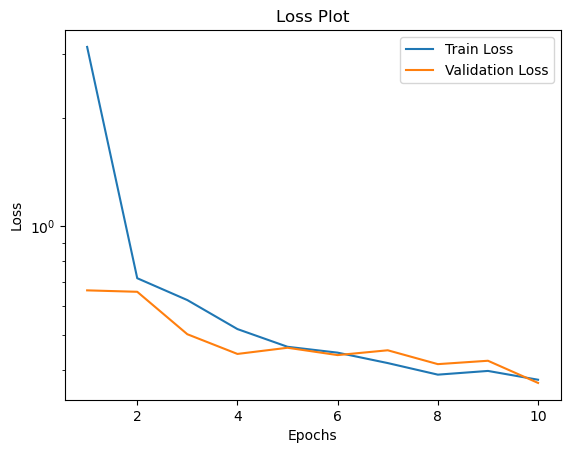

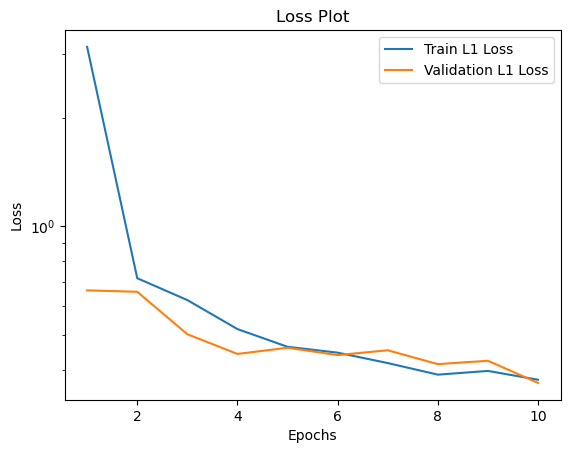

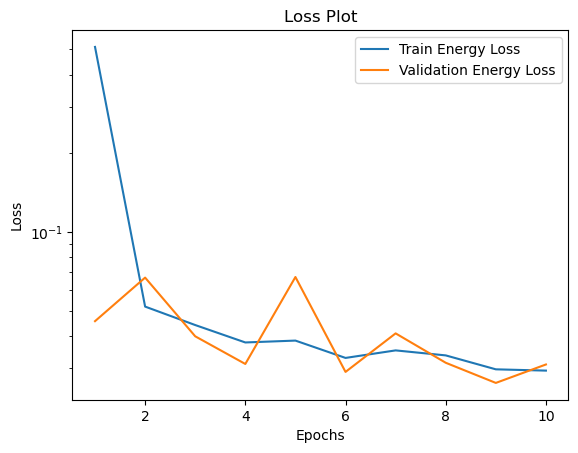

Test Loop:   0%|          | 0/313 [00:00<?, ?batches/s]

(0.3717037277480665, 0.3717037277480665, 0.031319573389949465)

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model2 = WavefunctionPINN(channels=[16,32,64,128,256,512]).to(device)
optimizer = torch.optim.Adam(model2.parameters(),lr=0.0001)
loss_fn = nn.L1Loss(reduction='sum')

dx = 0.15686276297629764
energy_loss_fn = EnergyLoss(alpha=1,gamma=0,dx=dx,loss_fn=nn.L1Loss(reduction='mean'))
epochs = 10

input = 'potential'
target = 'wavefunction2'
wavefunction_train(model2,epochs,train_dataloader,validation_dataloader,optimizer,loss_fn,energy_loss_fn,input=input,target=target,device=device)
wavefunction_test(model2,test_dataloader,loss_fn,energy_loss_fn,input=input,target=target,validate=False,device=device)

In [53]:
#torch.save(model2.state_dict(), 'Data/Models/model_state_dict.pt')

## Results

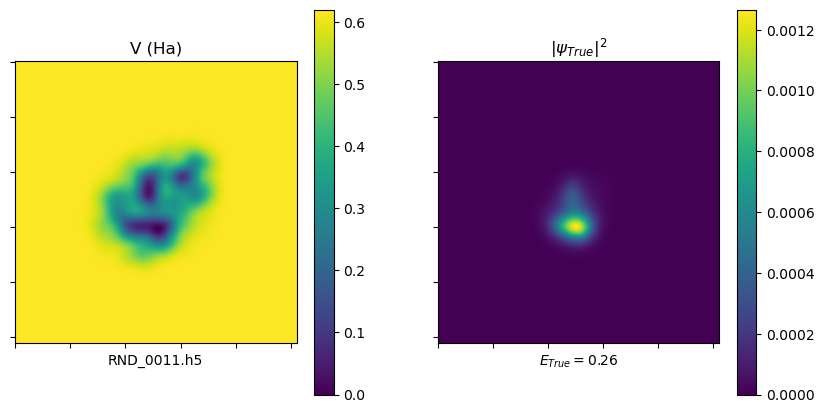

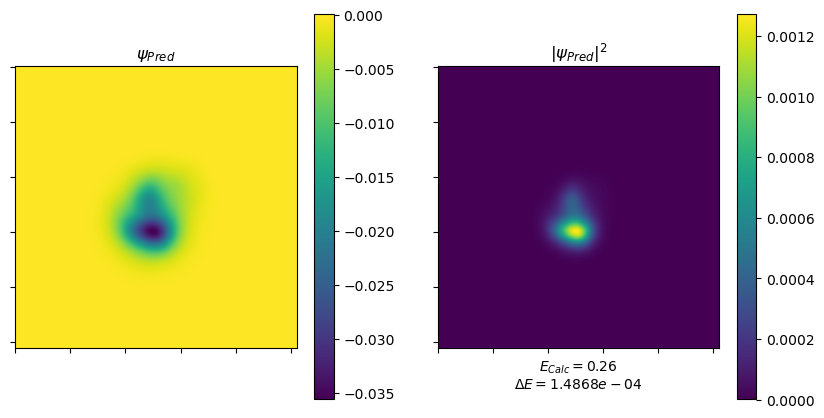

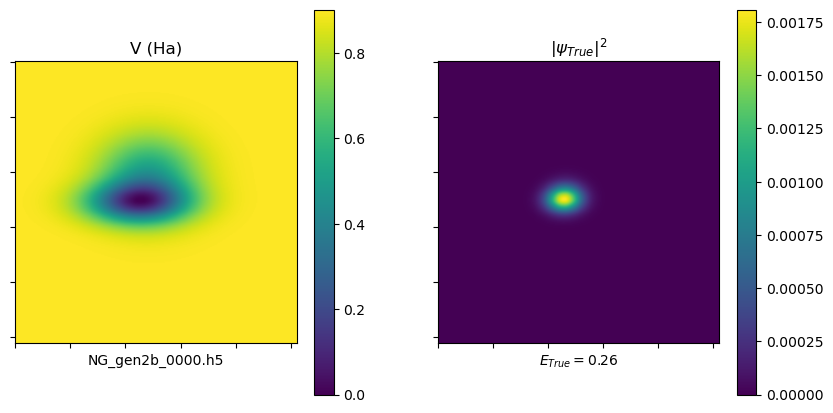

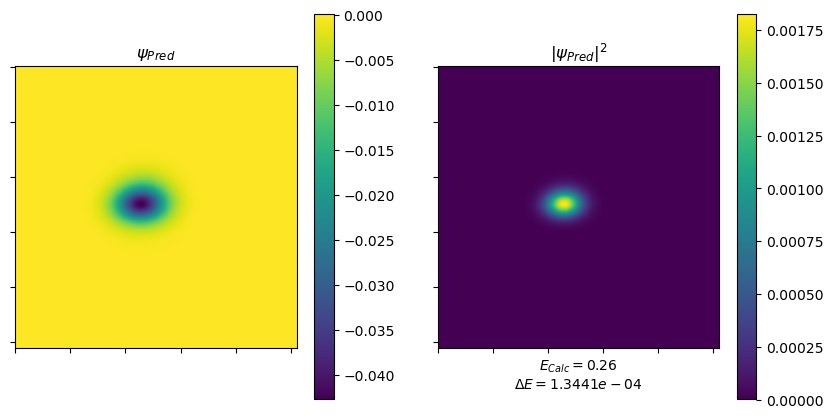

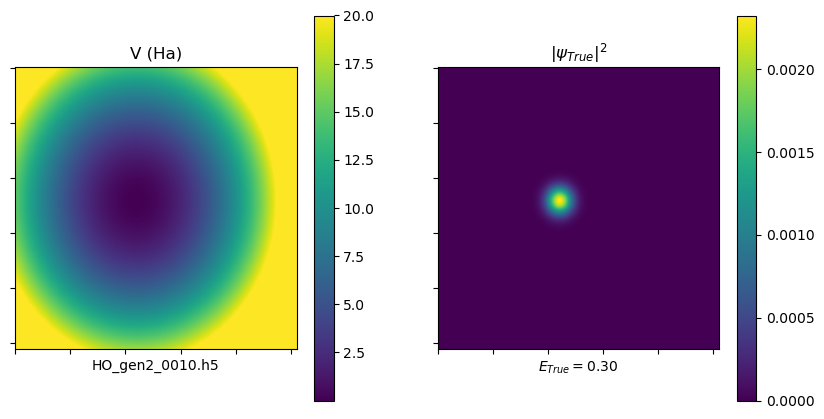

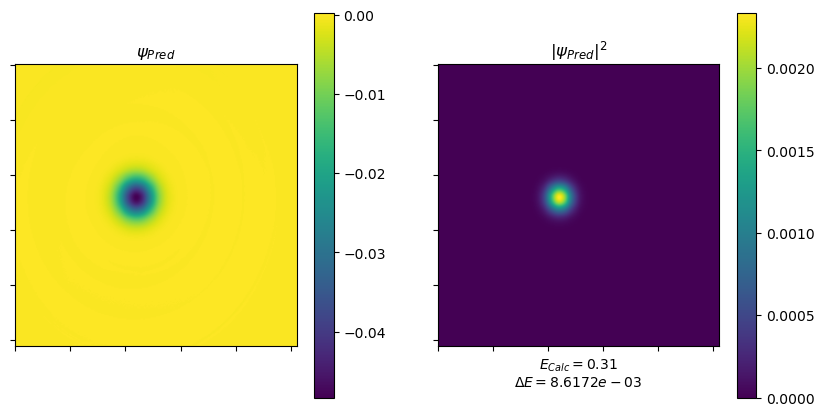

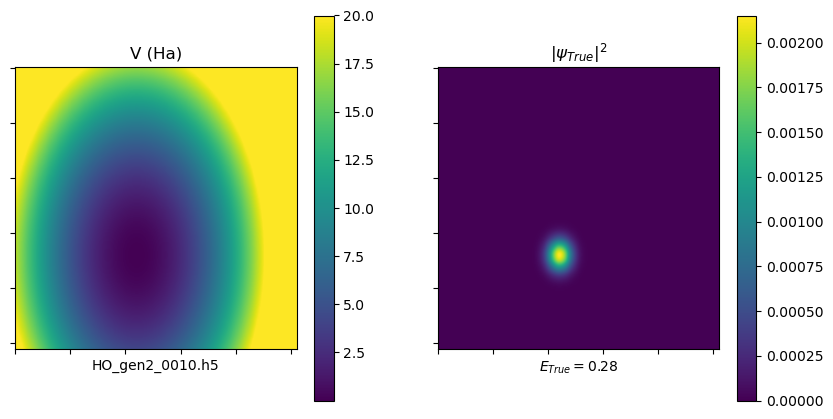

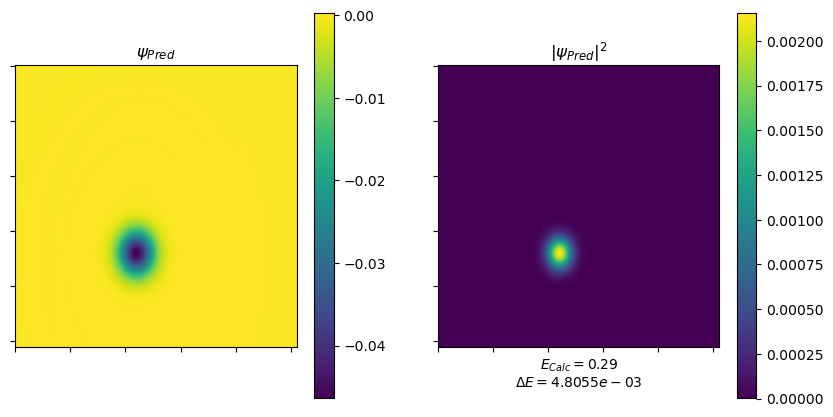

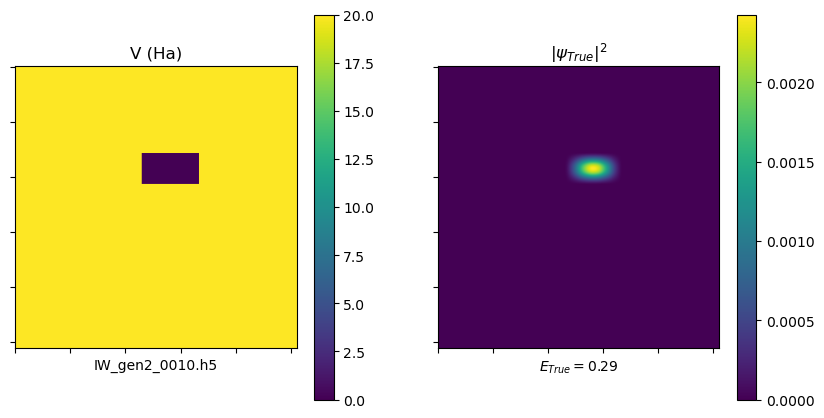

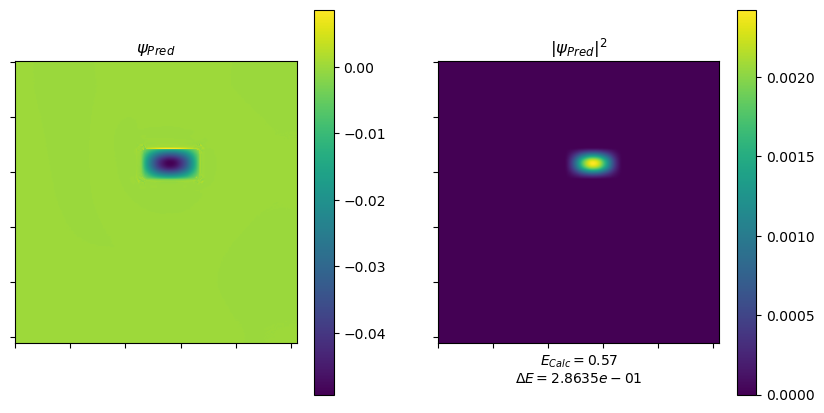

In [54]:
presentation_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

limit = 5
model2.eval()
for i, data in enumerate(presentation_dataloader):
    if i >= limit:
        break
    potential = data['potential'].to(device)
    wavefunction = data['wavefunction2'].to(device)
    energy = data['energy']
    potential_label = data['potential_label']
    X = data[input].to(device)
    with torch.inference_mode():
        wf = model2.forward(X)
        wavefunction_guess = wf**2
        energy_guess = energy_loss_fn.get_energy(potential,wf)
        print_img(potential.squeeze(dim=0),wavefunction.squeeze(dim=0),'V (Ha)',rf'$|\psi_{{True}}|^2$',energy=energy,potential_label=potential_label,energy_diff=True)
        print_img(wf.squeeze(dim=0),wavefunction_guess.squeeze(dim=0),rf'$\psi_{{Pred}}$',rf'$|\psi_{{Pred}}|^2$',energy=energy,energy_pred=energy_guess,energy_diff=True)